## Analyze

Aim to determine whether early or late snow changes more year to year or place to place

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [2]:
from pyspark import SparkContext
sc = SparkContext(master="local[2]")

In [3]:
from pyspark.sql import SQLContext
from pyspark.sql import *

sqlContext = SQLContext(sc)

In [4]:
STAT, STAT_descr = pickle.load(open("../Data/STAT_NY.pickle", "rb"))
STAT.keys()

dict_keys(['SNOW_s20', 'TMIN_s20', 'TOBS', 'SNWD_s20', 'PRCP_s20', 'TOBS_s20', 'PRCP', 'TMAX', 'TMAX_s20', 'TMIN', 'SNOW', 'SNWD'])

In [5]:
state, measure = "NY", "SNWD"

df = sqlContext.read.parquet("../Data/decon_NY_SNWD.parquet/")
print("Total count : ", df.count())
df.show(3)

Total count :  8174
+-----------+-----------+--------------------+----+------------------+------------------+-------------------+------------------+------------------+------------------+----------------+------------------+------------------+---------+------------------+------------------+------------------+------------------+-------------------+------------------+---------+-----+
|    Station|Measurement|              Values|Year|           coeff_1|           coeff_2|            coeff_3|           coeff_4|           coeff_5|        dist_coast|       elevation|          latitude|         longitude|     name|             res_1|             res_2|             res_3|             res_4|              res_5|          res_mean|total_var|State|
+-----------+-----------+--------------------+----+------------------+------------------+-------------------+------------------+------------------+------------------+----------------+------------------+------------------+---------+------------------+----

In [6]:
feature = "coeff_2"
sqlContext.registerDataFrameAsTable(df, "weather")

In [7]:
query = """
SELECT station, year, coeff_2
FROM weather
"""

df2 = sqlContext.sql(query)
df2.show(5)

+-----------+----+-------------------+
|    station|year|            coeff_2|
+-----------+----+-------------------+
|USW00014735|1939| -169.3223185674074|
|USW00014735|1943|  272.3540924503061|
|USW00014735|1945|  790.5793887906391|
|USW00014735|1947|-216.30283228614437|
|USW00014735|1948|  1028.612178846539|
+-----------+----+-------------------+
only showing top 5 rows



In [8]:
pdf = df2.toPandas()
pdf.head()

,station,year,coeff_2
0,USW00014735,1939,-169.322319
1,USW00014735,1943,272.354092
2,USW00014735,1945,790.579389
3,USW00014735,1947,-216.302832
4,USW00014735,1948,1028.612179


In [9]:
year_station_df = pdf.pivot(index="year", columns="station", values="coeff_2")
year_station_df.tail()

station,USC00300015,USC00300023,USC00300047,USC00300055,USC00300063,USC00300077,USC00300085,USC00300090,USC00300093,USC00300159,...,USW00014786,USW00014797,USW00014798,USW00094704,USW00094725,USW00094728,USW00094745,USW00094789,USW00094790,USW00094794
year,,,,,,,,,,,,,,,,,,,,,
2009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,870.773867,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-31.805303,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011,NaN,NaN,NaN,-120.642691,472.534062,NaN,NaN,NaN,907.925667,NaN,...,NaN,NaN,NaN,NaN,NaN,806.258001,NaN,NaN,NaN,NaN
2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013,NaN,149.013363,NaN,NaN,0.977231,NaN,97.643753,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Text(0, 0.5, 'number of stations')

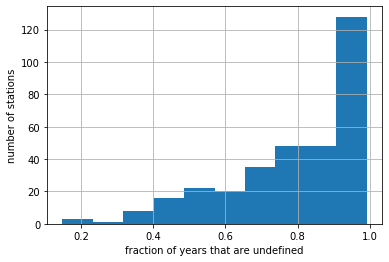

In [10]:
null_stations = pd.isnull(year_station_df).mean()
null_stations.hist()
plt.xlabel("fraction of years that are undefined")
plt.ylabel("number of stations")

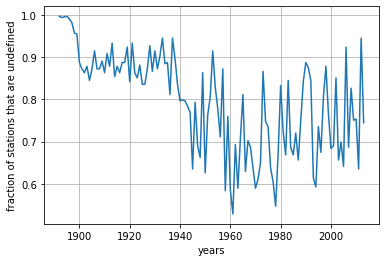

In [11]:
null_years = pd.isnull(year_station_df).mean(axis=1)
null_years.plot()
plt.xlabel("years")
plt.ylabel("fraction of stations that are undefined")
plt.grid()

In [12]:
# based on above observations, range of dataset > 1960

pdf2 = pdf[pdf["year"] > 1960]
year_station_df = pdf2.pivot(index="year", columns="station", values="coeff_2")
year_station_df.tail()

station,USC00300023,USC00300055,USC00300063,USC00300077,USC00300085,USC00300093,USC00300183,USC00300220,USC00300321,USC00300331,...,USW00014768,USW00014771,USW00014786,USW00014798,USW00094725,USW00094728,USW00094745,USW00094789,USW00094790,USW00094794
year,,,,,,,,,,,,,,,,,,,,,
2009,NaN,NaN,NaN,NaN,NaN,870.773867,576.598705,NaN,580.459651,NaN,...,NaN,627.812099,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010,NaN,NaN,NaN,NaN,NaN,-31.805303,-25.393217,NaN,-188.964850,-531.836350,...,-177.099611,156.548016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011,NaN,-120.642691,472.534062,NaN,NaN,907.925667,305.092413,NaN,561.781691,566.875416,...,283.597976,584.134272,NaN,NaN,NaN,806.258001,NaN,NaN,NaN,NaN
2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013,149.013363,NaN,0.977231,NaN,97.643753,NaN,NaN,NaN,170.083352,43.373130,...,15.194207,86.764841,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Text(0, 0.5, 'number of stations')

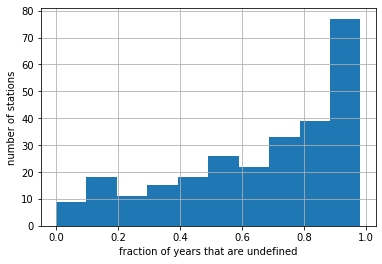

In [13]:
null_stations = pd.isnull(year_station_df).mean()
null_stations.hist()
plt.xlabel("fraction of years that are undefined")
plt.ylabel("number of stations")

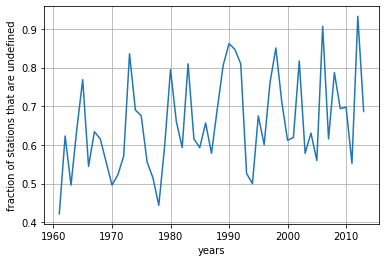

In [14]:
null_years = pd.isnull(year_station_df).mean(axis=1)
null_years.plot()
plt.xlabel("years")
plt.ylabel("fraction of stations that are undefined")
plt.grid()

## Estimate effect of year vs effect of location

In [15]:
def RMS(mat):
    return np.sqrt(np.nanmean(mat ** 2))

mean_by_year = np.nanmean(year_station_df, axis=1)
mean_by_station = np.nanmean(year_station_df, axis=0)
df_minus_year = (year_station_df.transpose() - mean_by_year).transpose()
df_minus_station = year_station_df - mean_by_station

print('total RMS = ', RMS(year_station_df))
print('\nRMS removing mean-by-station = ',RMS(df_minus_station),
      '\n\treduction = ', RMS(year_station_df) - RMS(df_minus_station))
print('\nRMS removing mean-by-year = ', RMS(df_minus_year),
      '\n\treduction=', RMS(year_station_df) - RMS(df_minus_year))

total RMS =  753.145449514645

RMS removing mean-by-station =  701.5445524111517 
	reduction =  51.60089710349325

RMS removing mean-by-year =  531.4823870967629 
	reduction= 221.6630624178821


## Conclusion

The effect of time is about four times as large as the effect of the location.

## Iterative Reduction

Using alternating minimization, to remove the combined effect of location and time.

In [16]:
print("Initial RMS : ", RMS(year_station_df))

for i in range(5):
    mean_by_year = np.nanmean(year_station_df, axis=1)
    year_station_df = (year_station_df.transpose() - mean_by_year).transpose()
    print("{} : after removing mean_by_year = {}".format(i, RMS(year_station_df)))
    
    mean_by_station = np.nanmean(year_station_df, axis=0)
    year_station_df = year_station_df - mean_by_station
    print("{} : after removing mean_by_stations  = {}".format(i, RMS(year_station_df)))

Initial RMS :  753.145449514645
0 : after removing mean_by_year = 531.4823870967629
0 : after removing mean_by_stations  = 490.58111029852466
1 : after removing mean_by_year = 490.11149394795615
1 : after removing mean_by_stations  = 490.08333935027764
2 : after removing mean_by_year = 490.08010695597295
2 : after removing mean_by_stations  = 490.0794679008307
3 : after removing mean_by_year = 490.0793022334803
3 : after removing mean_by_stations  = 490.0792548676868
4 : after removing mean_by_year = 490.0792408655066
4 : after removing mean_by_stations  = 490.0792366758466


In [17]:
year_station_df["mean_by_year"] = mean_by_year
year_station_df.head()

station,USC00300023,USC00300055,USC00300063,USC00300077,USC00300085,USC00300093,USC00300183,USC00300220,USC00300321,USC00300331,...,USW00014771,USW00014786,USW00014798,USW00094725,USW00094728,USW00094745,USW00094789,USW00094790,USW00094794,mean_by_year
year,,,,,,,,,,,,,,,,,,,,,
1961,155.322668,NaN,NaN,-526.216490,810.626258,-279.421801,142.485364,-202.849172,125.324071,129.805635,...,173.516964,0.0,79.791976,-1149.083768,-59.314214,1018.590878,NaN,99.364223,84.199898,-0.115733
1962,NaN,NaN,NaN,194.606475,-162.816631,42.324686,274.137805,-166.422647,NaN,NaN,...,NaN,NaN,NaN,170.828388,NaN,NaN,NaN,958.883579,-127.318680,-0.142607
1963,132.330101,NaN,NaN,490.657507,542.845673,301.262188,188.568372,294.201819,197.149024,148.849368,...,230.112110,NaN,59.291399,-208.082968,NaN,NaN,NaN,624.245549,-5.480156,-0.143292
1964,NaN,NaN,NaN,NaN,243.330515,435.685952,NaN,-121.596578,NaN,NaN,...,-294.370434,NaN,-121.120404,-359.614187,NaN,NaN,NaN,NaN,-242.508398,-0.149812
1965,NaN,NaN,NaN,NaN,36.324879,NaN,NaN,-732.826859,NaN,NaN,...,-69.694317,NaN,NaN,135.953933,NaN,NaN,NaN,NaN,-128.899506,-0.130511


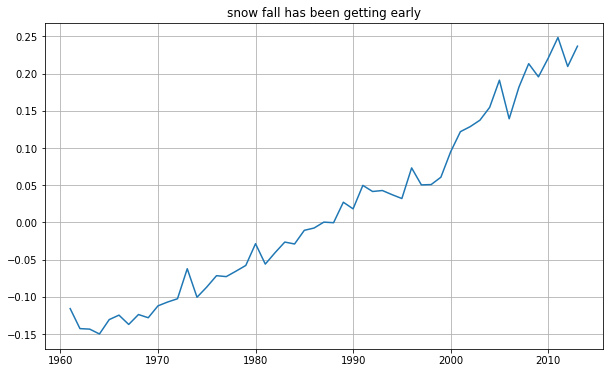

In [18]:
plt.figure(figsize=[10, 6])
plt.plot(year_station_df["mean_by_year"])
plt.title("snow fall has been getting early")
plt.grid()